In [1]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath('..'))

import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import matplotlib.patches as patches
import torch
import copy
import sys
sys.path.append("/Users/LOCCO_Louise/Documents/Git/code_amaury")
from simu_PSF_polarMFM import *
from extract_experimental_psf import *
from tqdm import tqdm
import time

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using GPU")
else:   
    device = torch.device('cpu')
    print("Using CPU")

Using GPU


In [3]:
d = np.array([1.1643099, 1.4462458, 1.7931267])
d = np.array([np.mean(d)-0.350, np.mean(d), np.mean(d)+0.350])
QE = 0.92
EM = 250
sensitivity = 15.4

In [4]:
Nframe=15

In [5]:
raw = np.zeros((Nframe,6,214,129))

In [6]:
path_info = '\\\\NAS_LOCCO\\Amaury\\DATA\\PolMFM_SilicaBeads_SLB_NR\\image_Pos0_2.ome_results_fr1to8095_method=Propagation matrix_box-method=Fixed_invertRotationPolarizer_corr.csv'

In [7]:
def extract_frames(frame_0, N_frame):
    error_indices = []
    for i in range(N_frame):
        number = str(frame_0 + i).zfill(4)
        print(number)
        path_data = '\\\\NAS_LOCCO\\Amaury\\DATA\\PolMFM_SilicaBeads_SLB_NR\\2024-01-11_SilicaBeads_Lipids_NR\\001_SM_560nm_EM250_25ms\\SilicaBead\\images\\RAW_DATA\\image_Pos0_2_reco\\image_Pos0_2_'+number+'.tif'
        raw_ = extract_raw(path_data)
        if raw_ is None:
            error_indices.append(i)
            continue
        else:
            raw[i] = raw_
        del(raw_)
    return raw, error_indices

def extract_positions(frame_0, N_frame, error_indices):
    index_frame = []
    x, y, z, rho, delta = [], [], [], [], []
    ind = 0
    for i in range(N_frame):
        if i not in error_indices:
            x__, y__, z__, rho__, delta__ = position_from_data(data, frame_0+i)
            x = np.concatenate((x, x__))
            y = np.concatenate((y, y__))
            z = np.concatenate((z, z__))
            rho = np.concatenate((rho, rho__))
            delta = np.concatenate((delta, delta__))
            for k in range(len(x__)):
                index_frame.append(ind)
        ind+=1
    index_frame=np.array(index_frame)
    return x, y, z, rho, delta, index_frame

def limit(x, lim, slope, upper=True):
    '''
    if upper:
       return torch.sum(torch.tensor(1/(1+torch.exp(-slope*(x-lim))), requires_grad=True, device=device))
    else:
        return torch.sum(torch.tensor(1/(1+torch.exp(slope*(x-lim))), requires_grad=True, device=device))
    '''
    if upper:
        return torch.sum(torch.exp((x-lim)*slope))
    else:
        return torch.sum(torch.exp(-1*(x-lim)*slope))
    
def loss_pos(xp, yp, zp, rho, eta, delta, N_photons, data, second_plane, background, sigma, dim_simu):
    u, v, M_ = compute_M(xp=xp, yp=yp, zp=zp, d=d_, x=xx, y=yy, th1=th1, phi=phi, Ex0=Ex0, Ex1=Ex1, Ex2=Ex2
                    , Ey0=Ey0, Ey1=Ey1, Ey2=Ey2, r=r, r_cut=r_cut, k=k_, f_o=f_o, phase_maskx=phase_mask, phase_masky=phase_mask, zernike_base=zernike_base, zernike_coefs_x=zernike_coefs_x, zernike_coefs_y=zernike_coefs_x,
                        second_plane=second_plane, polar_projections=polar_projections, N=N,
                    l_pixel=l_pixel, NA=NA, mag=mag, lambd=lambd, f_tube=f_tube, MAG=MAG, device=device, polar_offset=0., polar_offset2=0.)
    dim_data = 6
    h = PSF(rho=rho, eta=eta, delta=delta, M=M_, N_photons=N_photons)[:,:,:,dim_simu-dim_data:dim_simu+dim_data+1,dim_simu-dim_data:dim_simu+dim_data+1]
    loss = torch.sum(torch.add(h, -(data+sigma**2)*torch.log(h+background+sigma**2)))
    #loss = torch.sum(torch.pow(torch.sum(torch.add(h, -data), dim=(2,)), 2)) 
    x_bound = limit(xp, 5*0.12, 100, upper=True) + limit(xp, -5*0.12, 100, upper=False)
    y_bound = limit(yp, 5*0.12, 100, upper=True) + limit(yp, -5*0.12, 100, upper=False)
    z_bound = limit(zp, 5., 100, upper=True) + limit(zp, 0, 100, upper=False)
    N_bound = limit(N_photons, 10000., 0.01, upper=True)
    return loss +x_bound+y_bound+z_bound#+N_bound

def loss_angle(M_, rho, eta, delta, N_photons, data, background, sigma, dim_simu):
    dim_data = 6
    h = PSF(rho=rho, eta=eta, delta=delta, M=M_, N_photons=N_photons)[:,:,:,dim_simu-dim_data:dim_simu+dim_data+1,dim_simu-dim_data:dim_simu+dim_data+1]

    loss = torch.sum(torch.add(h, -(data+sigma**2)*torch.log(h+background+sigma**2)))
    #loss = torch.sum(torch.pow(torch.sum(torch.add(h, -data), dim=(2,)), 2)) 
    delta_bound = limit(delta, 180, 100, upper=True) + limit(delta, 1, 100, upper=False)
    N_bound = limit(N_photons, 10000., 0.01, upper=True)
    return loss + 1000.*(delta_bound)# + N_bound) #+ 100000*torch.sum(h**2)

def loss_angle_with_M(polar_proj, polar_proj2, rho, eta, delta, N_photons, data, background, sigma, dim_simu):
    dim_data = 6
    u, v, M_ = compute_M(xp=x_found, yp=y_found, zp=z_found, d=d_, x=xx, y=yy, th1=th1, phi=phi, Ex0=Ex0, Ex1=Ex1, Ex2=Ex2
                    , Ey0=Ey0, Ey1=Ey1, Ey2=Ey2, r=r, r_cut=r_cut, k=k_, f_o=f_o, phase_masky=phase_mask, phase_maskx=phase_mask, zernike_base=zernike_base, zernike_coefs_x=zernike_coefs_x, zernike_coefs_y=zernike_coefs_x,
                        second_plane=second_plane, polar_projections=polar_projections, N=N,
                    l_pixel=l_pixel, NA=NA, mag=mag, lambd=lambd, f_tube=f_tube, MAG=MAG, device=device, polar_offset=polar_proj, polar_offset2=polar_proj2)
    h = PSF(rho=rho, eta=eta, delta=delta, M=M_, N_photons=N_photons)[:,:,:,dim_simu-dim_data:dim_simu+dim_data+1,dim_simu-dim_data:dim_simu+dim_data+1]
    
    loss = torch.sum(torch.add(h, -(data+sigma**2)*torch.log(h+background+sigma**2)))
    #loss = torch.sum(torch.pow(torch.sum(torch.add(h, -data), dim=(2,)), 2)) 
    delta_bound = limit(delta, 180, 100, upper=True) + limit(delta, 1, 100, upper=False)
    N_bound = limit(N_photons, 10000., 0.01, upper=True)
    return loss + 1000.*(delta_bound)# + N_bound) #+ 100000*torch.sum(h**2)

def score_eval(M_, rho, eta, delta, N_photons, data, background, sigma, dim_simu):
    dim_data = 6
    h = PSF(rho=rho, eta=eta, delta=delta, M=M_, N_photons=N_photons)[:,:,:,dim_simu-dim_data:dim_simu+dim_data+1,dim_simu-dim_data:dim_simu+dim_data+1]
    score = torch.sum(torch.add(h, -(data+sigma**2)*torch.log(h+background+sigma**2)), dim=(1,2,3,4))
    return score.numpy() 

In [8]:
data = pos_from_csv(path_info)

In [9]:
N_batch = 350 

In [10]:
batch_offset = 0

In [11]:
offset_count = 14.1
print(offset_count)

14.1


0001
0002
0003
0004
0005
0006
0007
0008
0009
0010
0011
0012
0013
0014
0015


C:\Users\Amaury\anaconda3\envs\amaury_gpu\lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 100/100 [00:44<00:00,  2.27it/s]


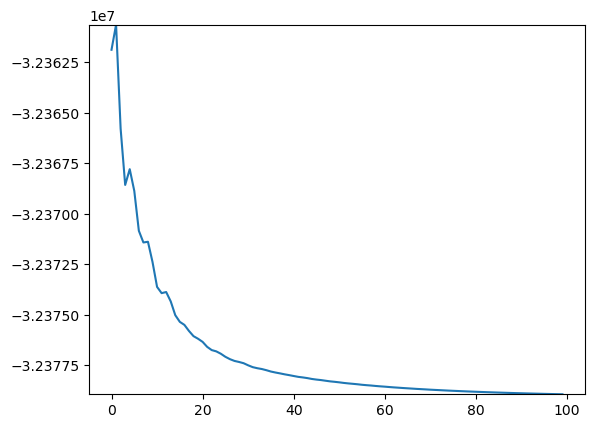

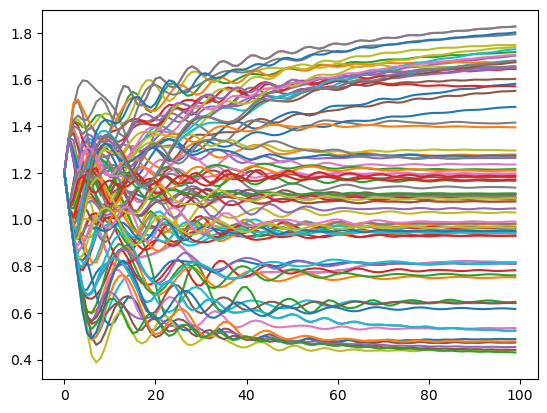

NPSF =  91


100%|██████████| 220/220 [03:03<00:00,  1.20it/s]


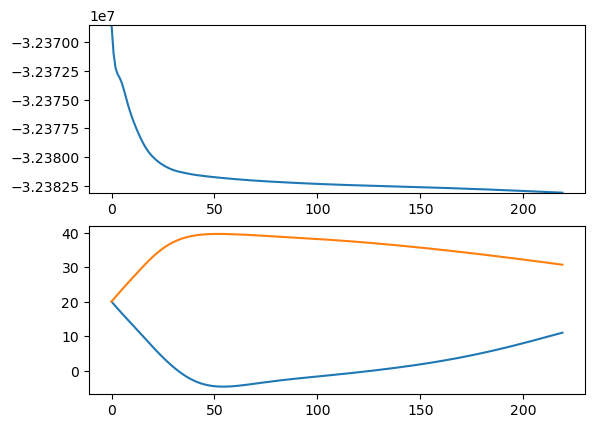

0016
0017
0018
0019
0020
0021
0022
0023
0024
0025
0026
0027
0028
0029
0030


100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


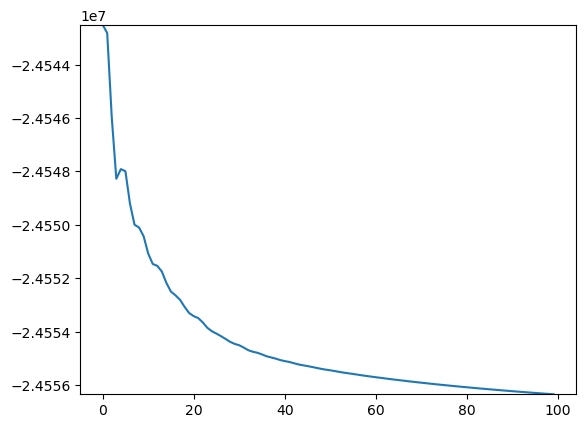

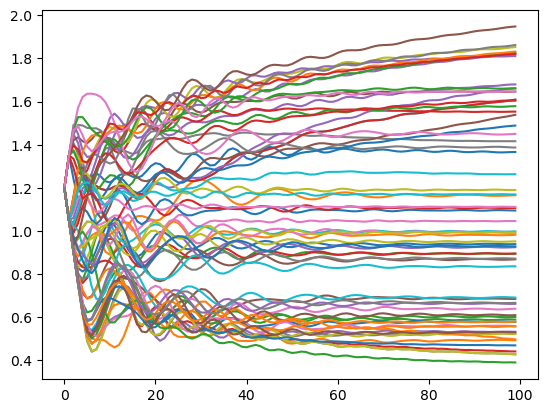

NPSF =  68


100%|██████████| 220/220 [02:39<00:00,  1.38it/s]


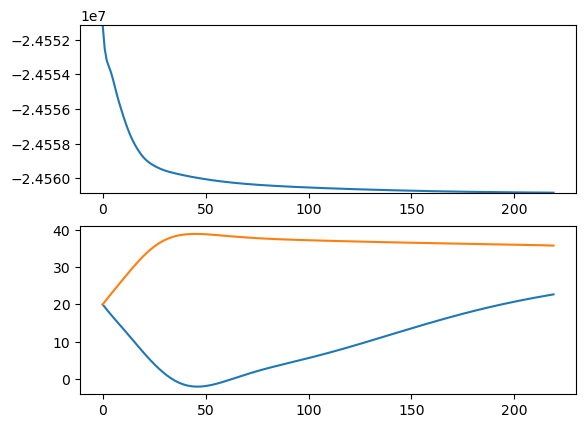

0031
0032
0033
0034
0035
0036
0037
0038
0039
0040
0041
0042
0043
0044
0045


100%|██████████| 100/100 [00:43<00:00,  2.28it/s]


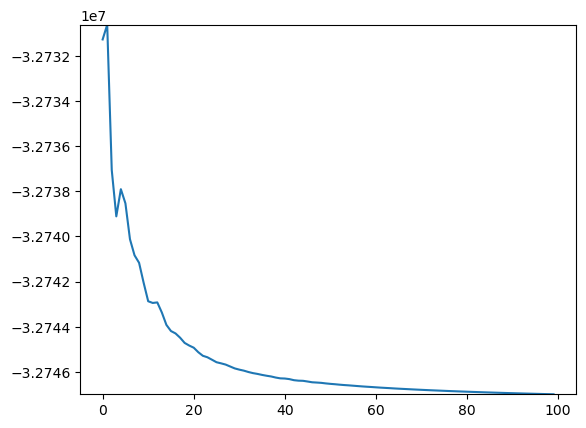

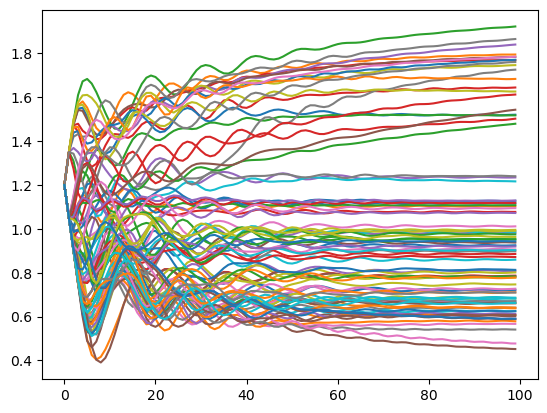

NPSF =  91


100%|██████████| 220/220 [03:03<00:00,  1.20it/s]


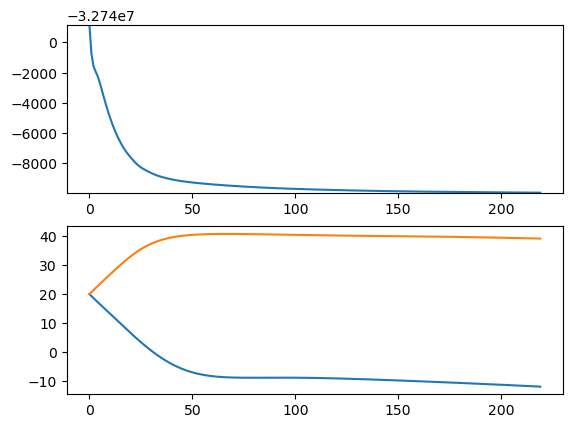

0046
0047
0048
0049
0050
0051
0052
0053
0054
0055
0056
0057
0058
0059
0060


100%|██████████| 100/100 [03:38<00:00,  2.18s/it]


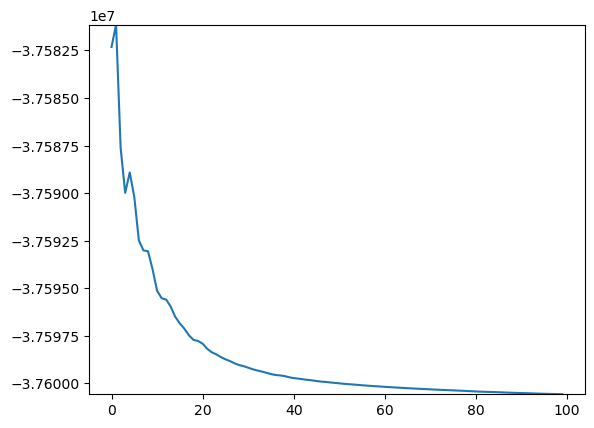

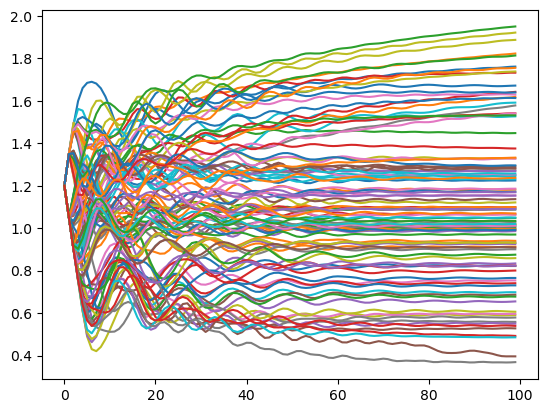

NPSF =  104


100%|██████████| 220/220 [11:25<00:00,  3.11s/it]


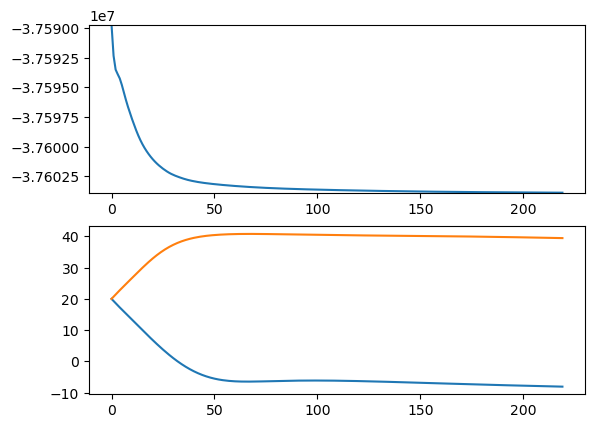

0061
0062
0063
0064
0065
0066
0067
0068
0069
0070
0071
0072
0073
0074
0075


100%|██████████| 100/100 [00:43<00:00,  2.32it/s]


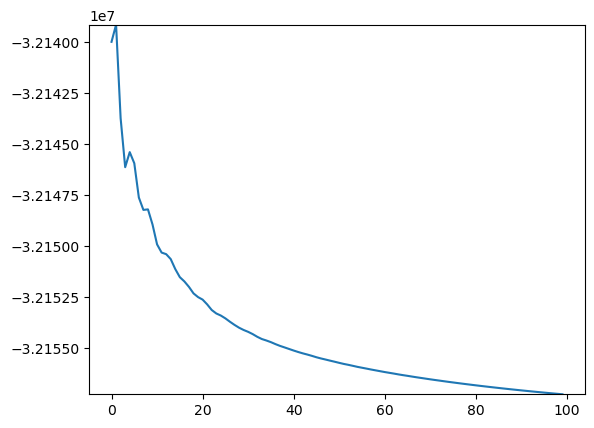

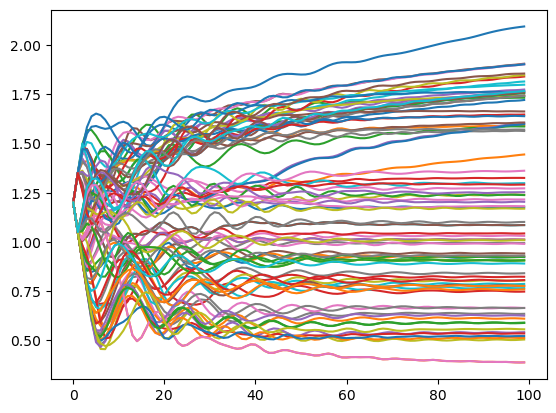

NPSF =  90


100%|██████████| 220/220 [03:01<00:00,  1.21it/s]


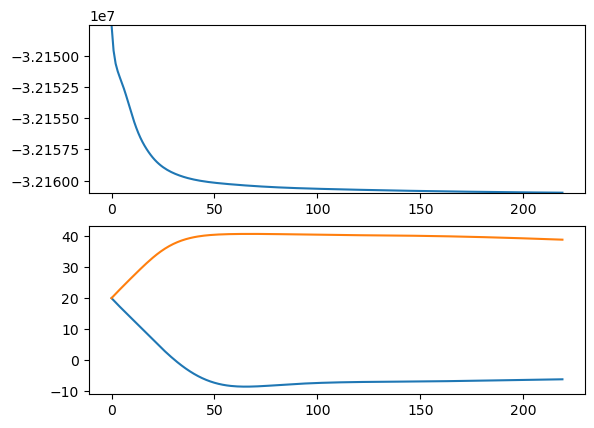

0076
0077
0078
0079
0080
0081
0082
0083
0084
0085
0086
0087
0088
0089
0090


100%|██████████| 100/100 [10:15<00:00,  6.16s/it]


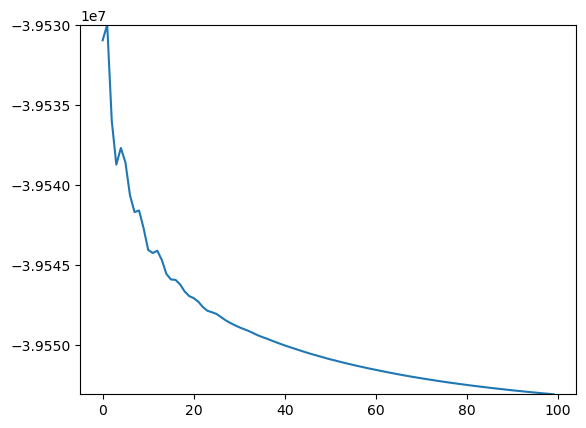

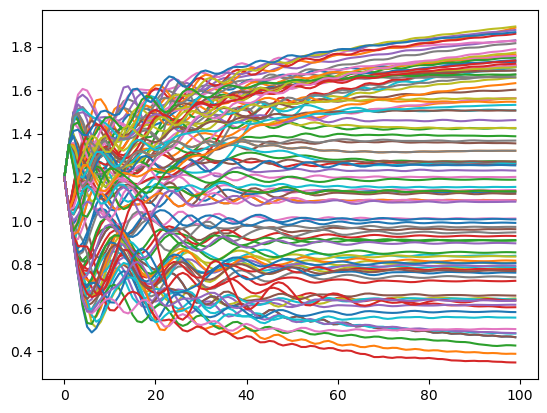

NPSF =  105


100%|██████████| 220/220 [25:19<00:00,  6.90s/it]


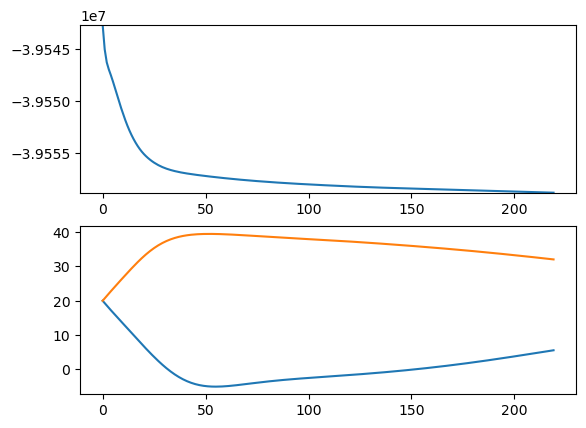

0091
0092
0093
0094
0095
0096
0097
0098
0099
0100
0101
0102
0103
0104
0105


100%|██████████| 100/100 [00:43<00:00,  2.28it/s]


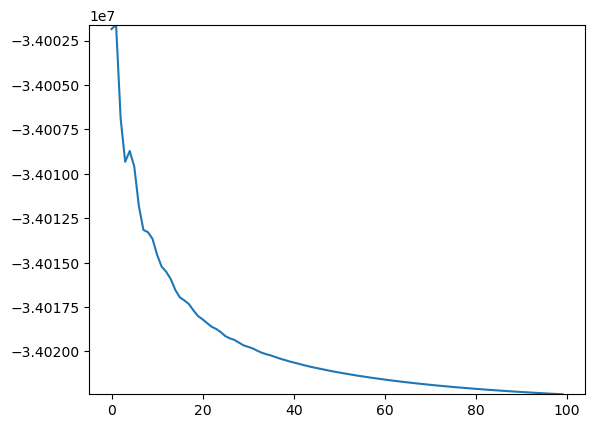

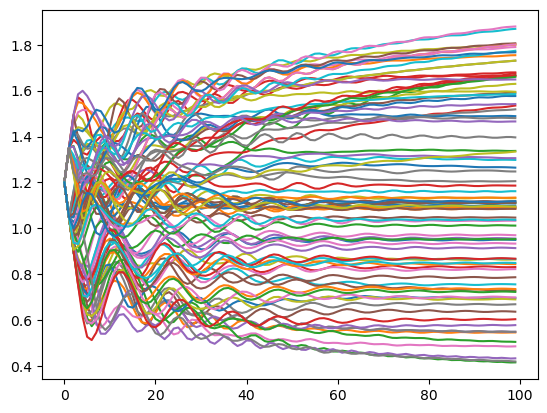

NPSF =  91


100%|██████████| 220/220 [03:03<00:00,  1.20it/s]


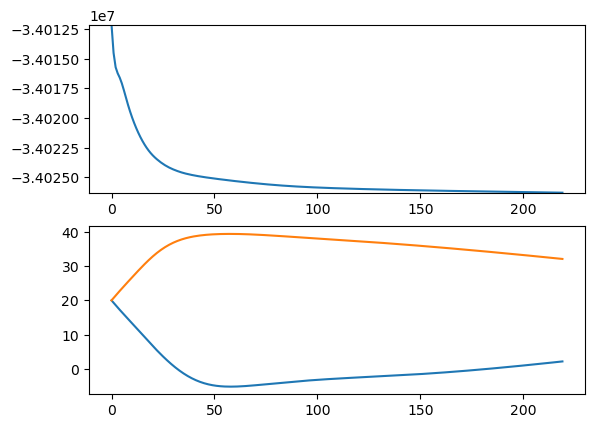

0106
0107
0108
0109
0110
0111
0112
0113
0114
0115
0116
0117
0118
0119
0120


100%|██████████| 220/220 [10:49<00:00,  2.95s/it]


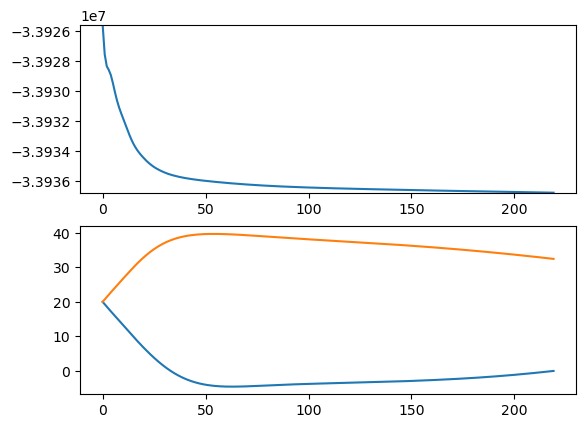

0121
0122
0123
0124
0125
0126
0127
0128
0129
0130
0131
0132
0133
0134
0135


100%|██████████| 100/100 [00:36<00:00,  2.73it/s]


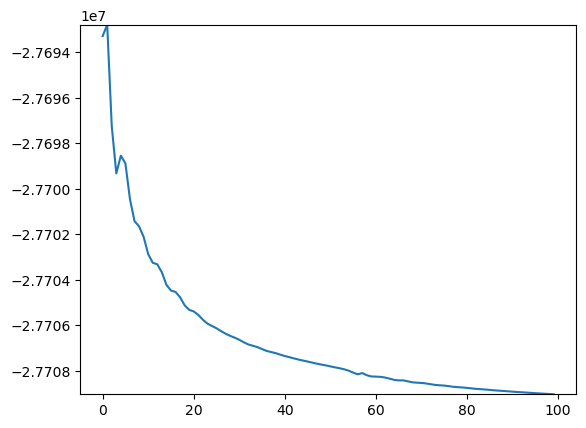

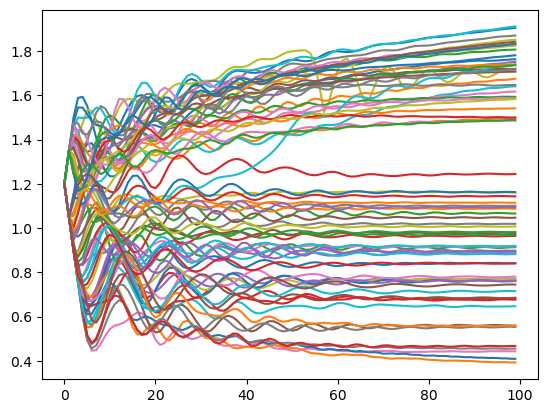

NPSF =  76


100%|██████████| 220/220 [02:47<00:00,  1.31it/s]


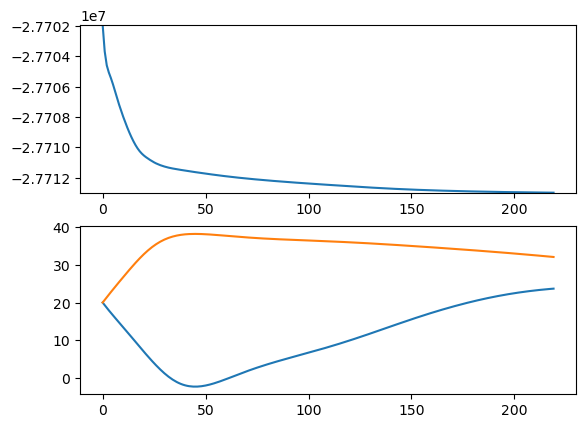

0136
0137
0138
0139
0140
0141
0142
0143
0144
0145
0146
0147
0148
0149
0150


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


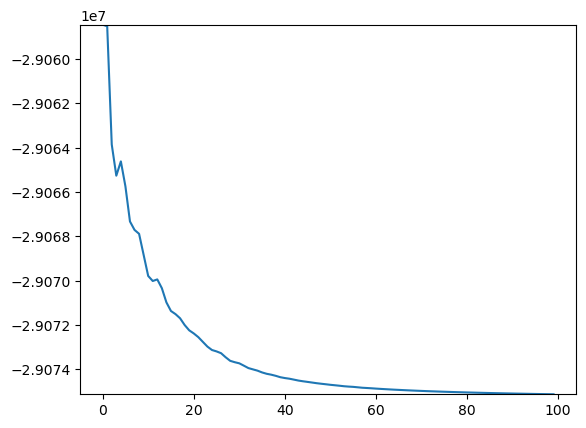

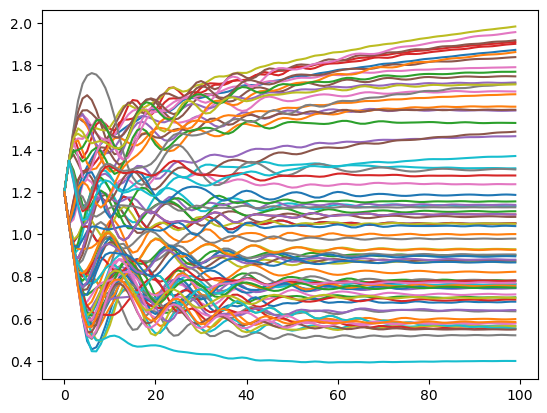

NPSF =  82


100%|██████████| 220/220 [02:53<00:00,  1.27it/s]


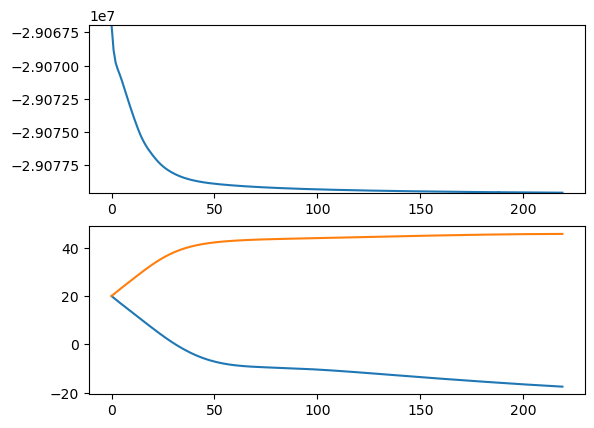

0151
0152
0153
0154
0155
0156
0157
0158
0159
0160
0161
0162
0163
0164
0165


100%|██████████| 100/100 [00:38<00:00,  2.57it/s]


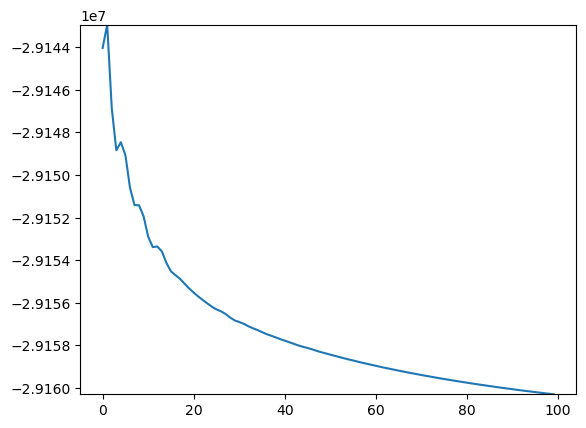

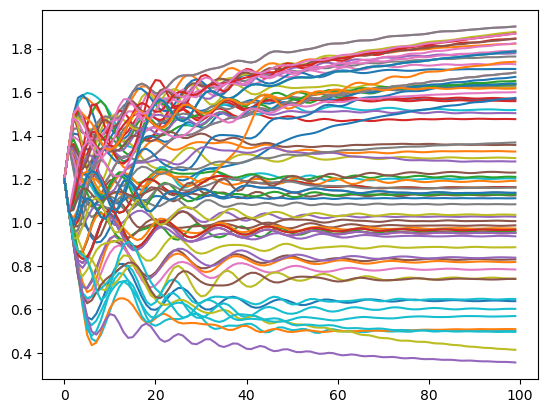

NPSF =  81


100%|██████████| 220/220 [02:52<00:00,  1.27it/s]


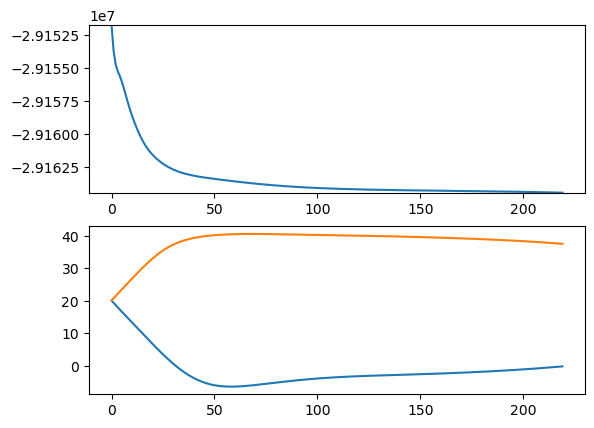

0166
0167
0168
0169
0170
0171
0172
0173
0174
0175
0176
0177
0178
0179
0180


100%|██████████| 100/100 [00:38<00:00,  2.59it/s]


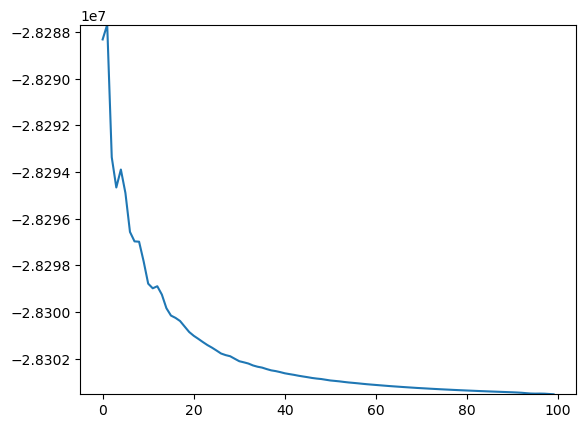

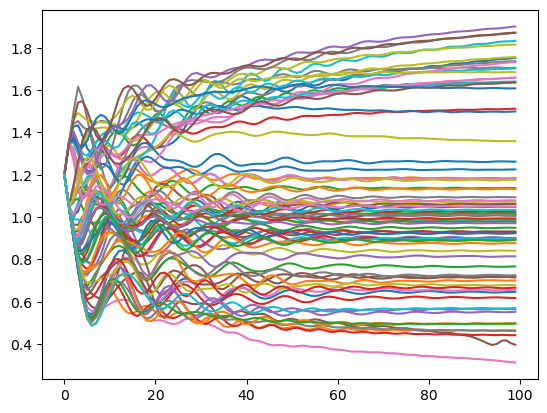

NPSF =  80


100%|██████████| 220/220 [02:51<00:00,  1.28it/s]


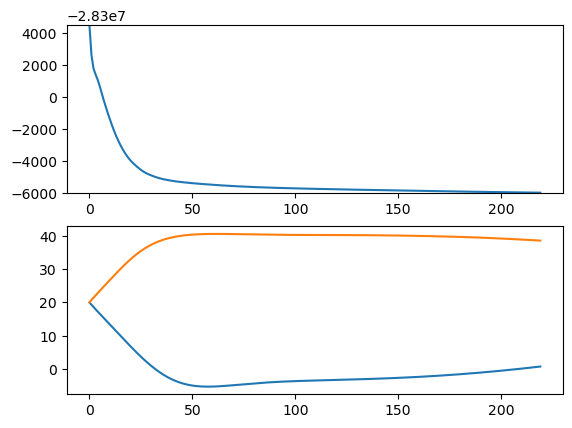

0181
0182
0183
0184
0185
0186
0187
0188
0189
0190
0191
0192
0193
0194
0195


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


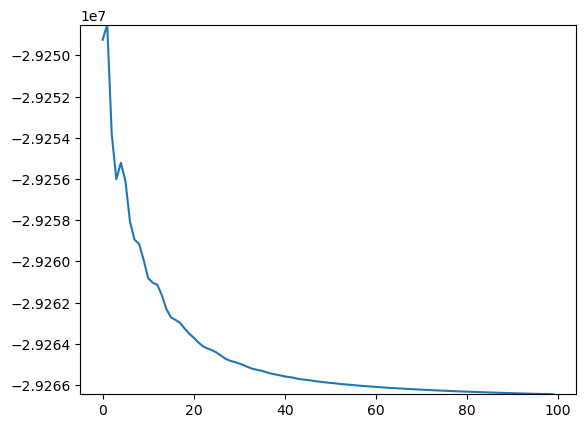

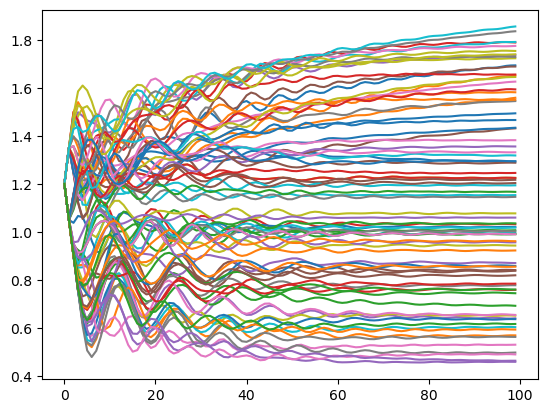

NPSF =  83


100%|██████████| 220/220 [02:54<00:00,  1.26it/s]


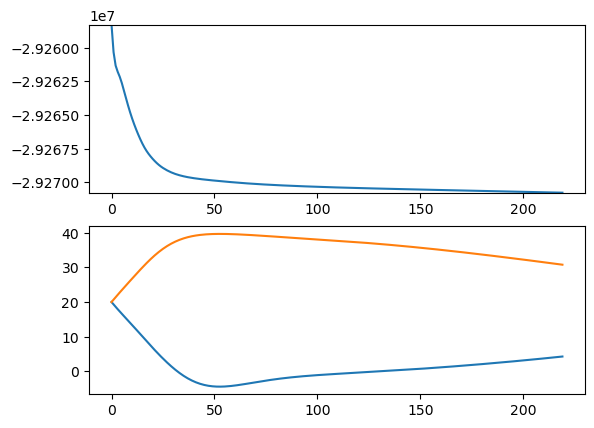

0196
0197
0198
0199
0200
0201
0202
0203
0204
0205
0206
0207
0208
0209
0210


100%|██████████| 100/100 [03:12<00:00,  1.93s/it]


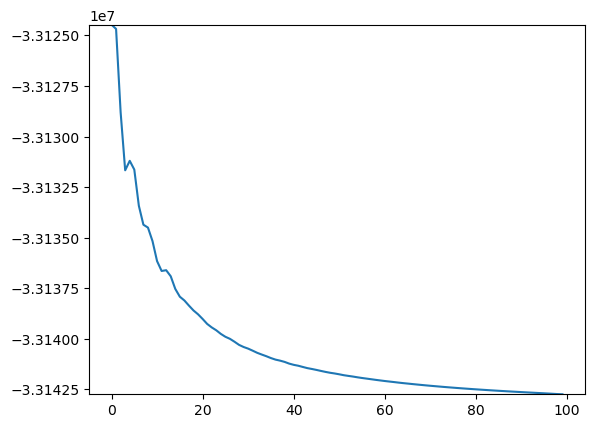

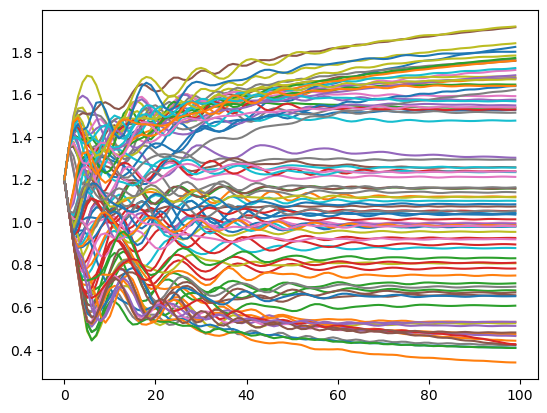

NPSF =  92


100%|██████████| 220/220 [11:27<00:00,  3.13s/it]


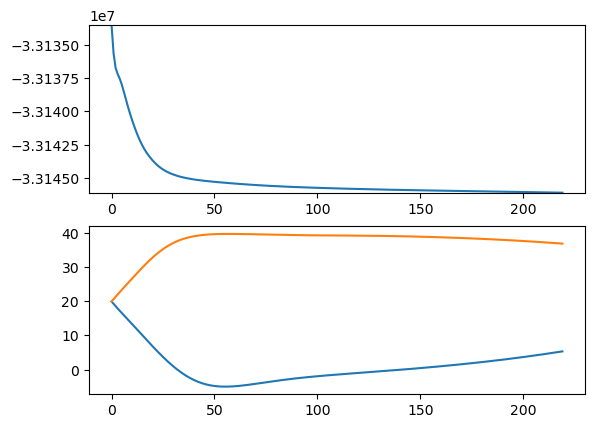

0211
0212
0213
0214
0215
0216
0217
0218
0219
0220
0221
0222
0223
0224
0225


100%|██████████| 100/100 [00:34<00:00,  2.87it/s]


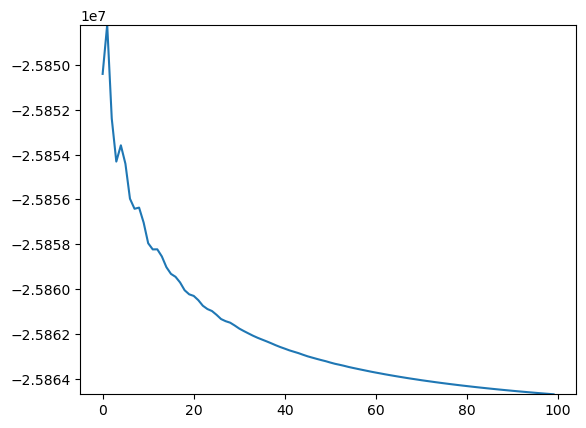

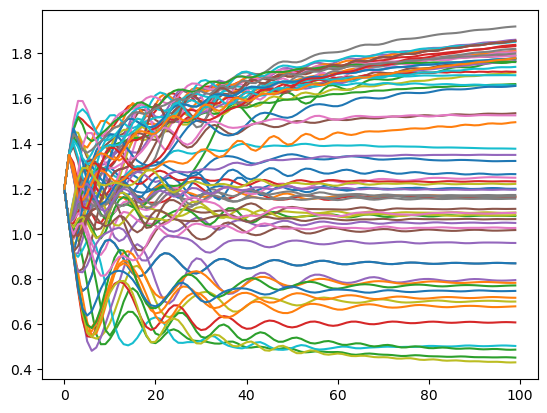

NPSF =  72


100%|██████████| 220/220 [02:43<00:00,  1.34it/s]


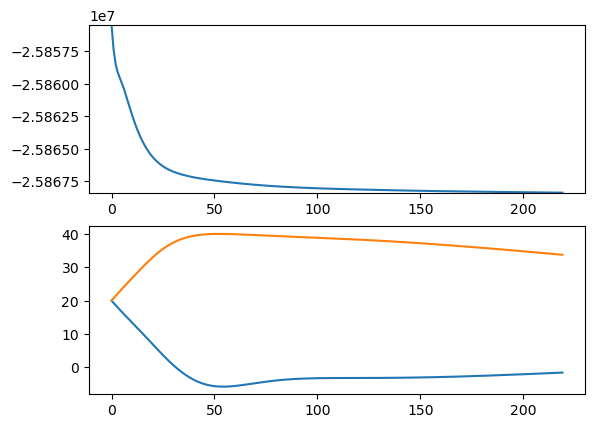

0226
0227
0228
0229
0230
0231
0232
0233
0234
0235
0236
0237
0238
0239
0240


100%|██████████| 100/100 [00:38<00:00,  2.56it/s]


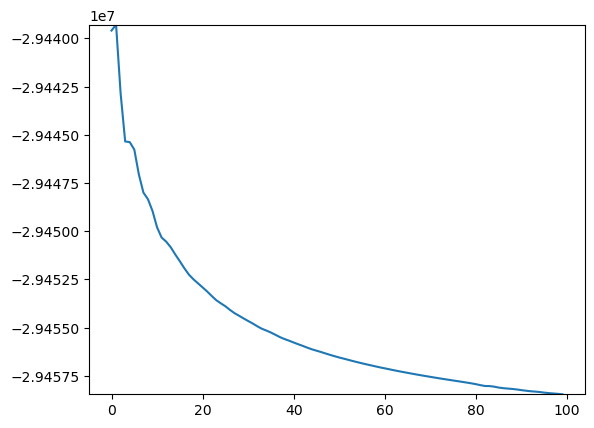

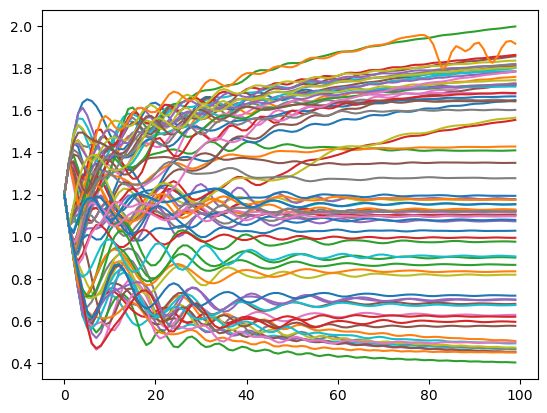

NPSF =  81


100%|██████████| 220/220 [02:52<00:00,  1.27it/s]


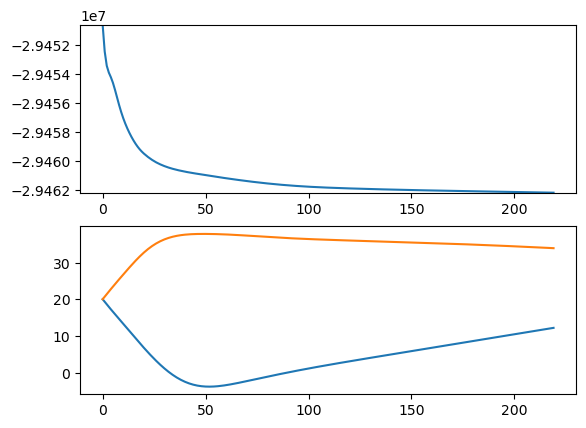

0241
0242
0243
0244
0245
0246
0247
0248
0249
0250
0251
0252
0253
0254
0255


100%|██████████| 100/100 [03:11<00:00,  1.92s/it]


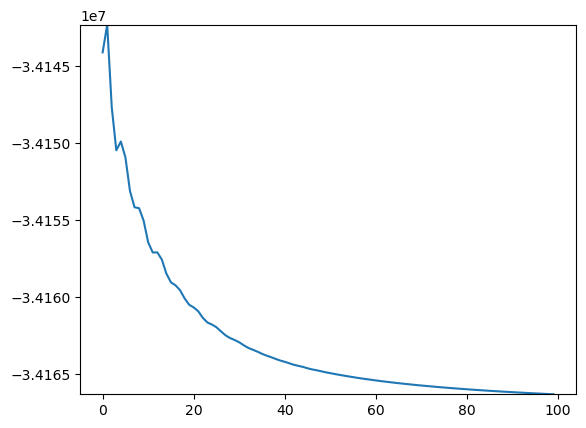

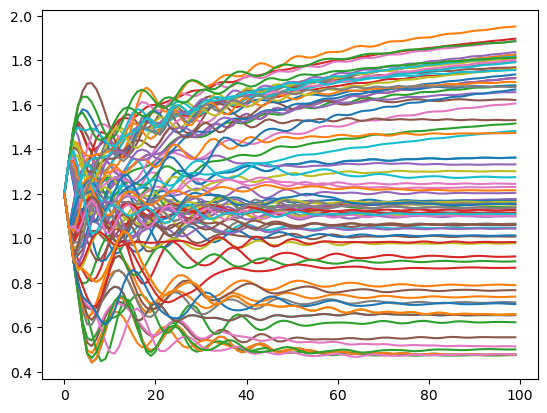

NPSF =  92


IOPub message rate exceeded.46<09:40,  3.12s/it]
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 220/220 [03:06<00:00,  1.18it/s]


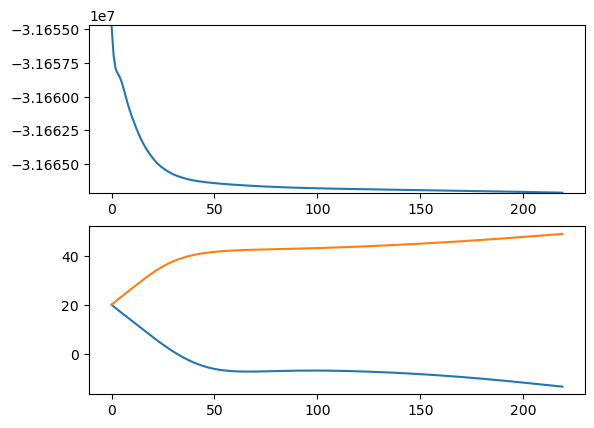

0361
0362
0363
0364
0365
0366
0367
0368
0369
0370
0371
0372
0373
0374
0375


100%|██████████| 100/100 [00:37<00:00,  2.65it/s]


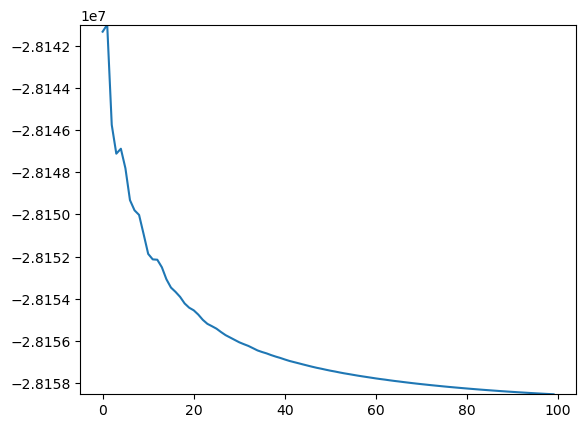

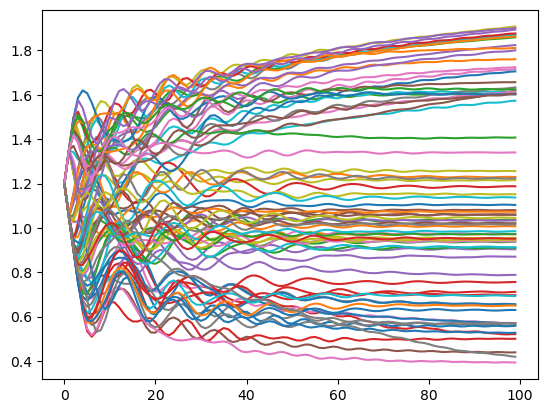

NPSF =  78


100%|██████████| 220/220 [02:49<00:00,  1.30it/s]


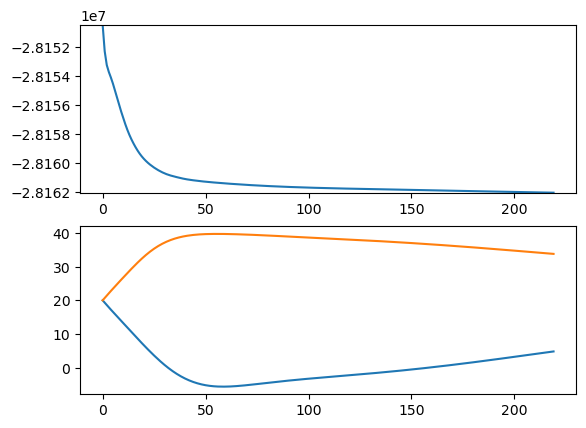

0376
0377
0378
0379
0380
0381
0382
0383
0384
0385
0386
0387
0388
0389
0390


100%|██████████| 100/100 [00:29<00:00,  3.44it/s]


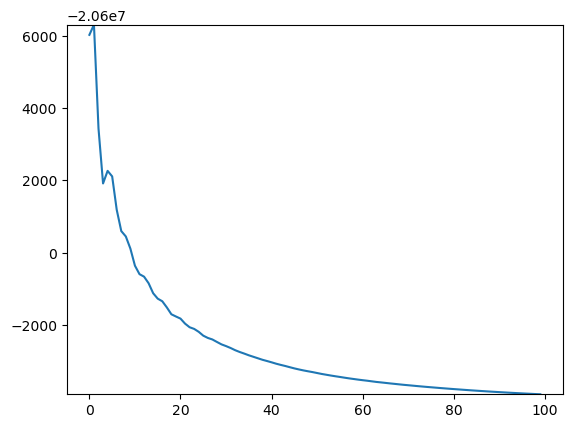

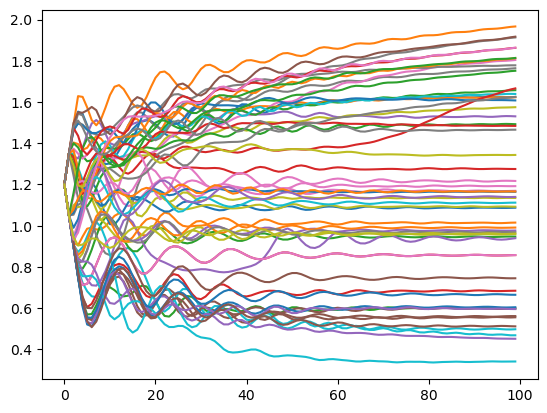

NPSF =  59


100%|██████████| 220/220 [02:31<00:00,  1.46it/s]


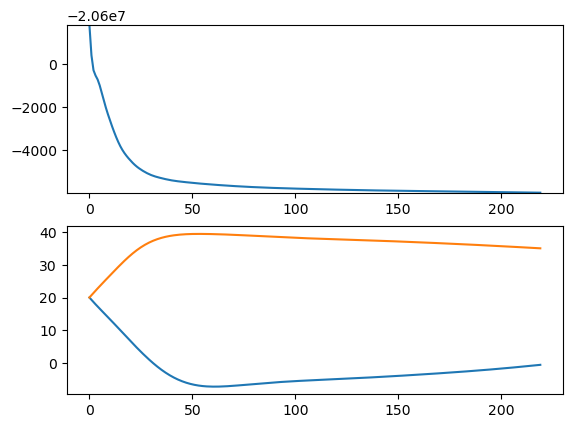

0391
0392
0393
0394
0395
0396
0397
0398
0399
0400
0401
0402
0403
0404
0405


100%|██████████| 100/100 [00:38<00:00,  2.63it/s]


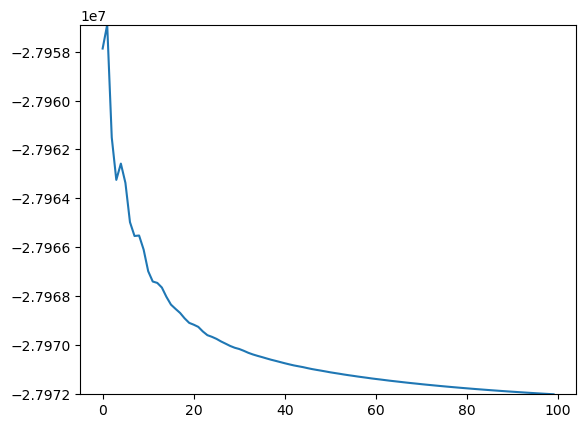

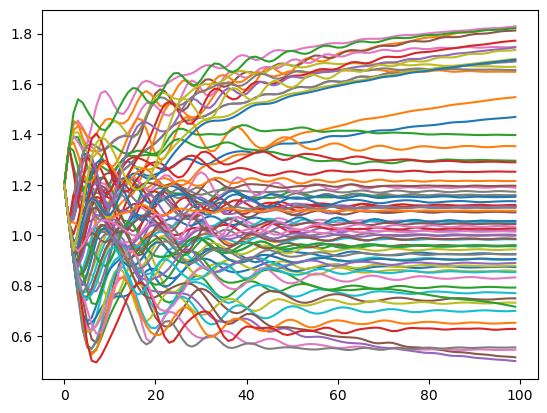

NPSF =  79


100%|██████████| 220/220 [02:50<00:00,  1.29it/s]


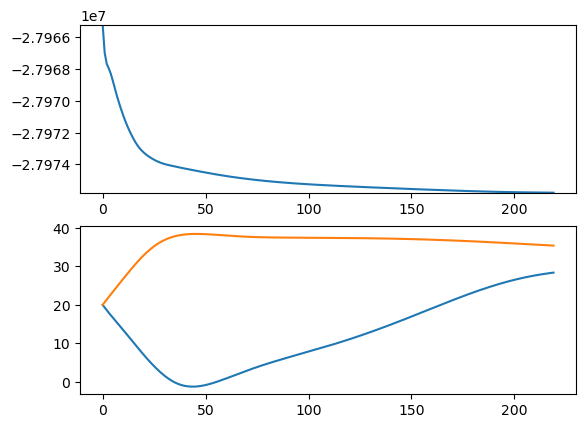

0406
0407
0408
0409
0410
0411
0412
0413
0414
0415
0416
0417
0418
0419
0420


100%|██████████| 100/100 [00:28<00:00,  3.51it/s]


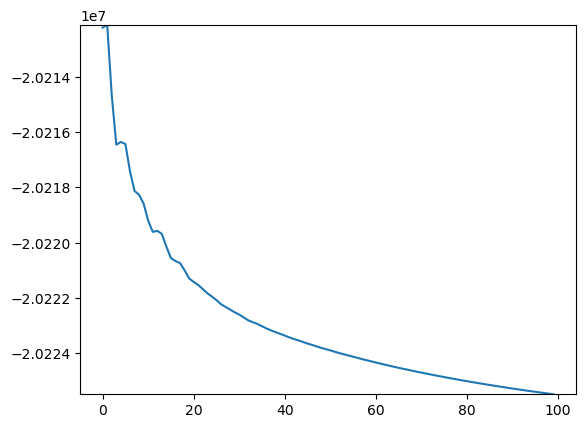

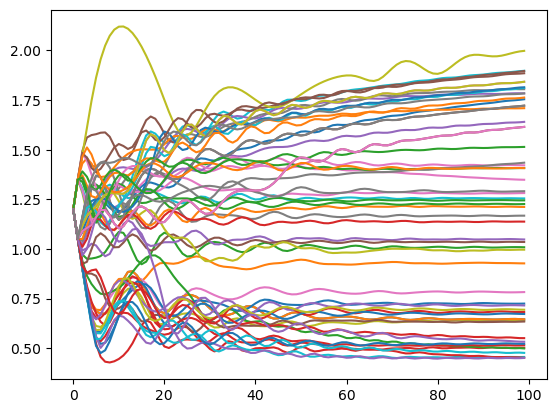

NPSF =  58


100%|██████████| 220/220 [02:29<00:00,  1.47it/s]


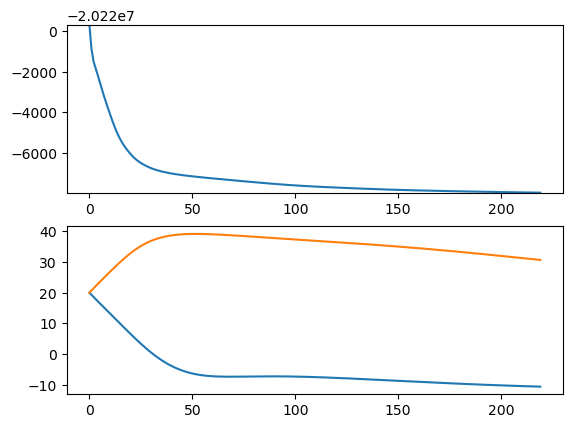

0421
0422
0423
0424
0425
0426
0427
0428
0429
0430
0431
0432
0433
0434
0435


100%|██████████| 100/100 [03:30<00:00,  2.10s/it]


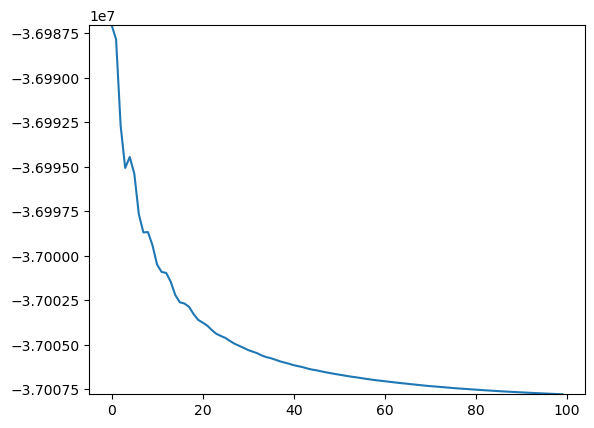

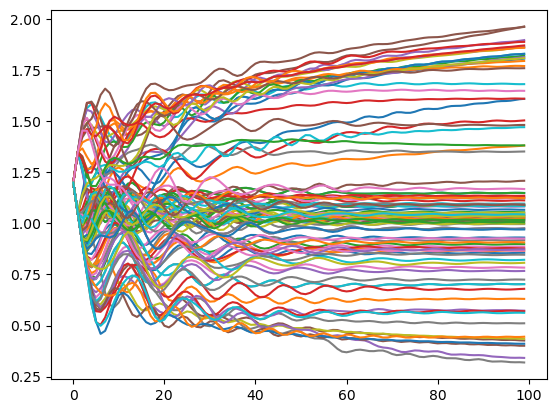

NPSF =  100


100%|██████████| 220/220 [10:58<00:00,  2.99s/it]


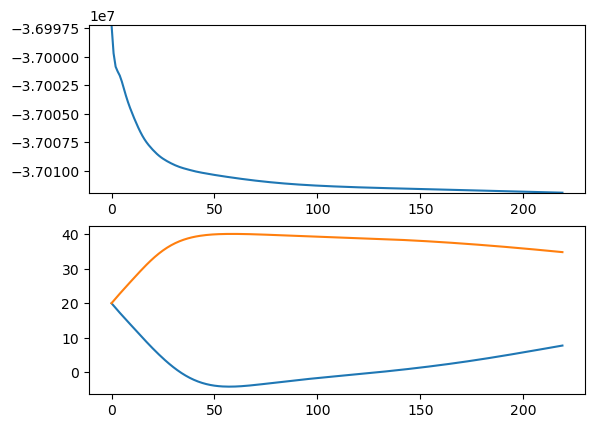

0436
0437
0438
0439
0440
0441
0442
0443
0444
0445
0446
0447
0448
0449
0450


100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


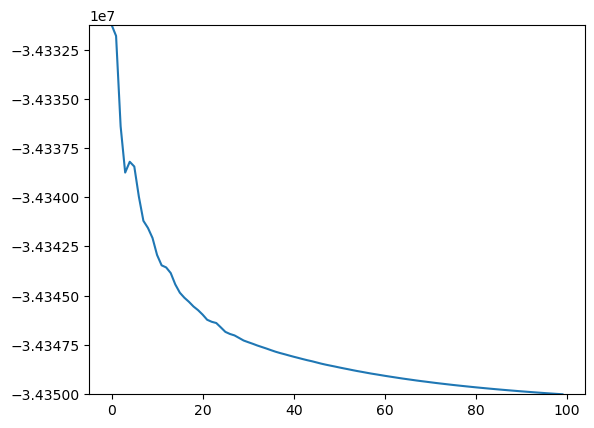

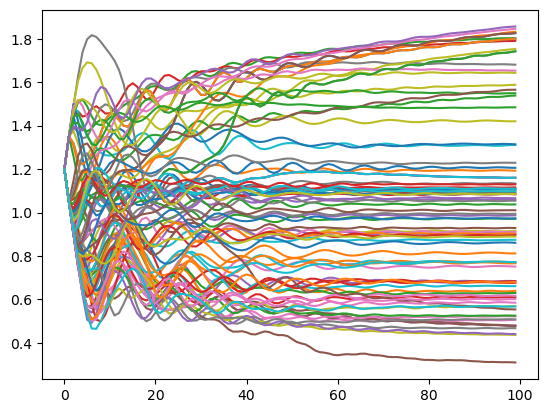

NPSF =  90


100%|██████████| 220/220 [03:02<00:00,  1.20it/s]


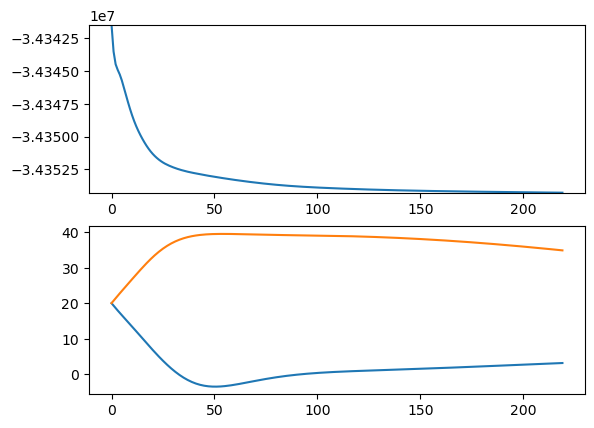

0451
0452
0453
0454
0455
0456
0457
0458
0459
0460
0461
0462
0463
0464
0465


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


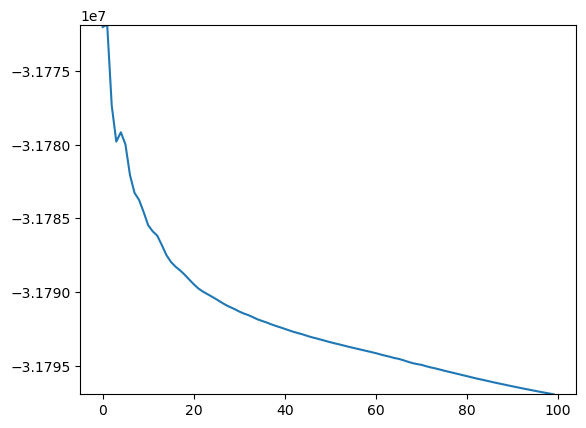

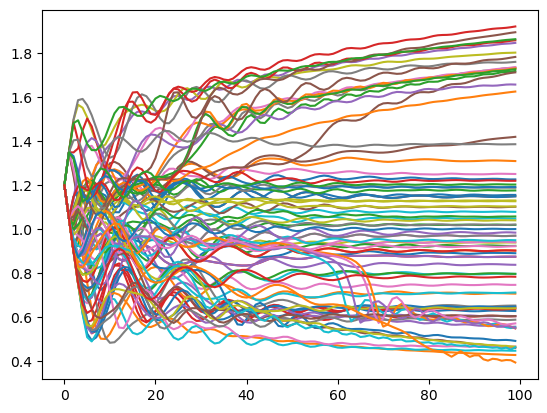

NPSF =  84


100%|██████████| 220/220 [02:56<00:00,  1.25it/s]


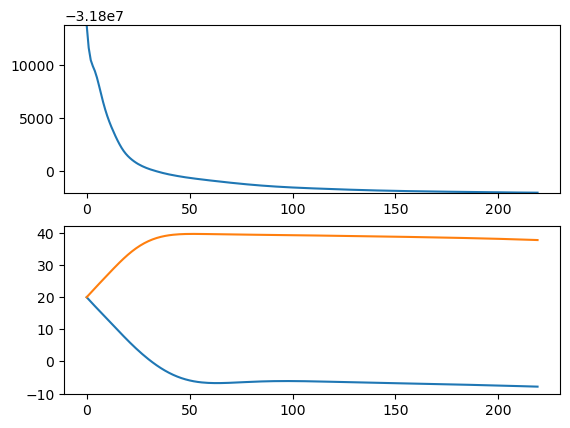

0466
0467
0468
0469
0470
0471
0472
0473
0474
0475
0476
0477
0478
0479
0480


100%|██████████| 100/100 [00:35<00:00,  2.79it/s]


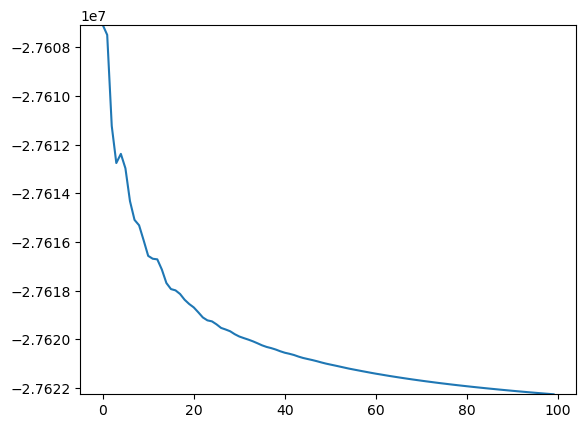

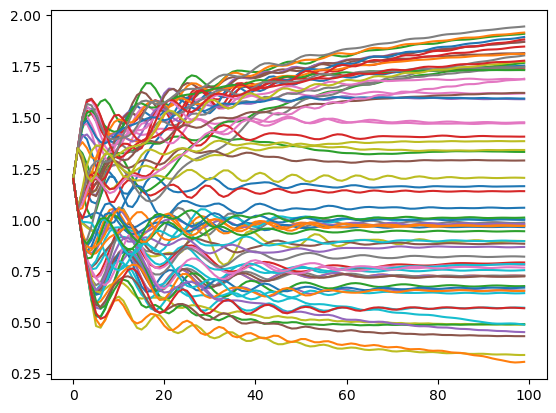

NPSF =  74


100%|██████████| 220/220 [02:54<00:00,  1.26it/s]


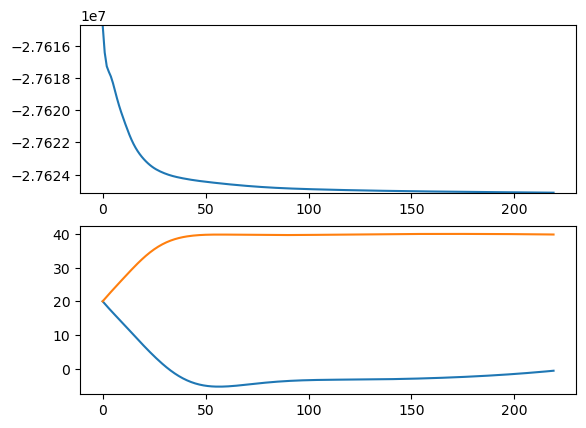

0481
0482
0483
0484
0485
0486
0487
0488
0489
0490
0491
0492
0493
0494
0495


100%|██████████| 100/100 [04:23<00:00,  2.63s/it]


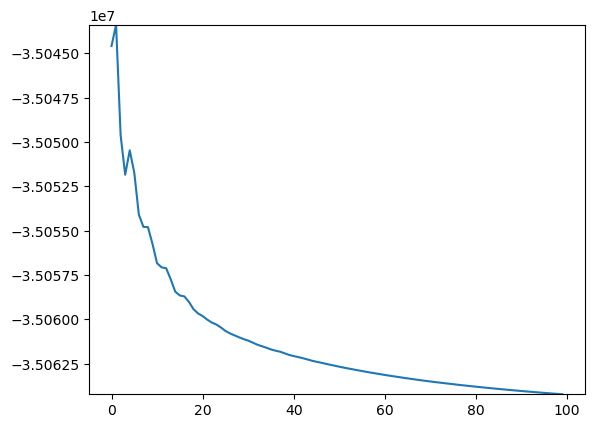

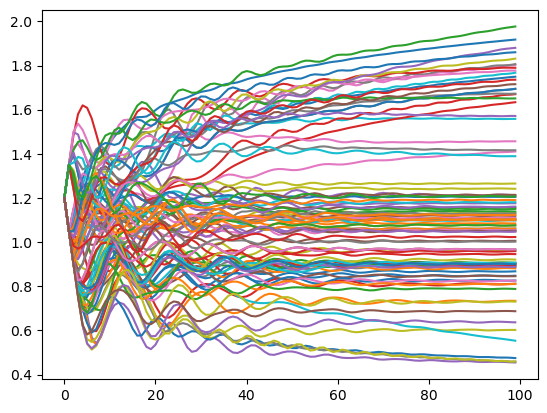

NPSF =  96


100%|██████████| 220/220 [12:00<00:00,  3.28s/it]


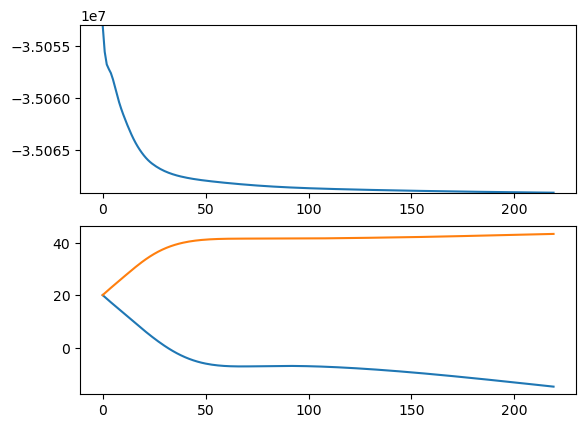

0496
0497
0498
0499
0500
0501
0502
0503
0504
0505
0506
0507
0508
0509
0510


100%|██████████| 100/100 [04:30<00:00,  2.70s/it]


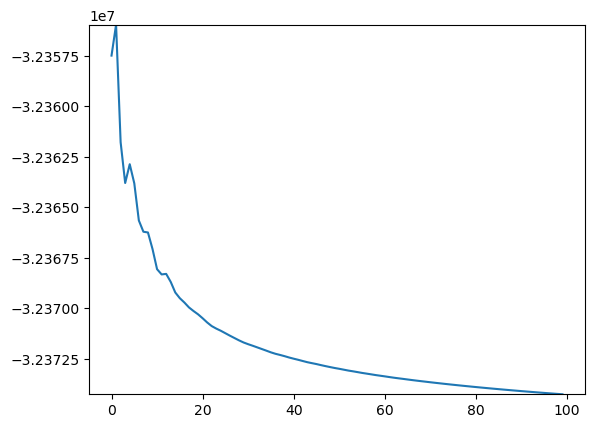

 57%|█████▋    | 126/220 [05:51<04:24,  2.82s/it]

In [ ]:
for batch_number in range(N_batch):
    t0 = time.time()
    raw, error_indices = extract_frames((batch_number+batch_offset)*Nframe+1, Nframe)
    x, y, z, rho, delta, index_frame = extract_positions((batch_number+batch_offset)*Nframe+1, Nframe, error_indices)
    raw = raw*sensitivity/(QE*EM)

    sigma = np.std(raw.flatten())
    background = np.mean(raw.flatten())

    nb = len(x)
    for k, ele in enumerate(x):
        if np.isnan(x[nb-1-k]) or np.isnan(y[nb-1-k]) or np.isnan(z[nb-1-k]) or np.isnan(rho[nb-1-k]) or np.isnan(delta[nb-1-k]):
            x = np.delete(x,nb-1-k,0)
            y = np.delete(y,nb-1-k,0)
            z = np.delete(z,nb-1-k,0)
            rho = np.delete(rho,nb-1-k,0)
            delta = np.delete(delta,nb-1-k,0)
            index_frame = np.delete(index_frame,nb-1-k,0)
    
    NPSF = len(x)

    single_psf = extract_raw_xy(raw[0], x[index_frame==0], y[index_frame==0])
    for i in range(1,Nframe):
        single_psf = np.concatenate((single_psf, extract_raw_xy(raw[i], x[index_frame==i], y[index_frame==i])))

    single_psf = single_psf[:,::-1]

    x_start = torch.tensor([0. for k in range(len(x))], requires_grad=False, device=device)
    y_start = torch.tensor([0. for k in range(len(x))], requires_grad=False, device=device)

    z_exp =  torch.tensor([1.2 for k in range(len(x))], requires_grad=False, device=device) 

    rho_exp = torch.tensor(rho, requires_grad=False, device=device)
    delta_exp = torch.tensor(delta, requires_grad=False, device=device)

    d_ = -torch.tensor([d[1] for k in range(len(x))], requires_grad=False, device=device)
    second_plane = torch.tensor([d[1]-d[0], 0, d[1]-d[2]])
    polar_projections = torch.tensor(np.array([0, 45, 0]))

    N=torch.tensor(80, device=device)
    l_pixel=torch.tensor(16, device=device)
    NA=torch.tensor(1.4, device=device)
    mag=torch.tensor(100, device=device)
    lambd=torch.tensor(638, device=device)
    f_tube=torch.tensor(200, device=device)
    MAG=torch.tensor(200/150, device=device)
    xx, yy, th1, phi, [Ex0, Ex1, Ex2], [Ey0, Ey1, Ey2], r, r_cut, k_, f_o = vectorial_BFP_perfect_focus(N, NA=NA, mag=mag, lambd=lambd, f_tube=f_tube, device=device)

    if batch_number==0:
        phase_mask = torch.stack([torch.ones((N,N), device=device), torch.ones((N,N), device=device), torch.ones((N,N), device=device)])
        zernike_base = generate_zernike_base(r_cut=r_cut, N=N, zernike_order=4, device=device)
        zernike_coefs_x = torch.zeros((3,15), device=device)
        zernike_coefs_y = torch.zeros((3,15), device=device)
    
    noisy_psf = torch.tensor([single_psf[k] for k in range(len(x))], device=device)

    u, v, M = compute_M(xp=x_start, yp=y_start, zp=z_exp, d=d_, x=xx, y=yy, th1=th1, phi=phi, Ex0=Ex0, Ex1=Ex1, Ex2=Ex2
                    , Ey0=Ey0, Ey1=Ey1, Ey2=Ey2, r=r, r_cut=r_cut, k=k_, f_o=f_o, phase_maskx=phase_mask, phase_masky=phase_mask, zernike_base=zernike_base, zernike_coefs_x=zernike_coefs_x, zernike_coefs_y=zernike_coefs_x,
                        second_plane=second_plane, polar_projections=polar_projections, N=N, l_pixel=l_pixel
                    , NA=NA, mag=mag, lambd=lambd, f_tube=f_tube, MAG=MAG, device=device, polar_offset=0., polar_offset2=0.)
    h = PSF(rho=torch.tensor(np.array([45. for k in range(NPSF)]), device=device), eta=torch.tensor([45. for k in range(NPSF)], device=device), delta=torch.tensor([100. for k in range(NPSF)], device=device), M=M, N_photons=torch.tensor([1000. for k in range(NPSF)], device=device))
    
    dim_simu = int(h.shape[-1]//2)

    ### first SGD on pos
    Nstart = torch.tensor([3000 for i in range(NPSF)], requires_grad=False, device=device)
    eta_rd = torch.tensor([45. for k in range(NPSF)], requires_grad=False, device=device)
    delta_rd = torch.tensor([150. for k in range(NPSF)], requires_grad=False, device=device)

    params = torch.cat((x_start, y_start, z_exp, Nstart/1000))
    params.requires_grad=True

    optimizer = torch.optim.Adam([params], lr=0.15)  # Learning rate = 0.012

    num_epochs_max = 100
    loss_ = []
    z__ = []
    for i in tqdm(range(num_epochs_max)):
        optimizer.zero_grad()  # Reset gradients
        loss = loss_pos(params[0:NPSF], params[NPSF:2*NPSF], params[2*NPSF:3*NPSF], rho_exp
                            , eta_rd, delta_exp, params[3*NPSF:4*NPSF]*1000, noisy_psf, second_plane, background, sigma, dim_simu) 
        loss_.append(loss.cpu().detach().numpy())
        z__.append(params[2*NPSF:3*NPSF].cpu().detach().numpy())
        loss.backward()  # Backpropagation
        optimizer.step()  # Update parameters
    ax = plt.plot(loss_)
    plt.ylim((np.min(np.array(loss_)), np.max(np.array(loss_))))
    plt.show()
    ax = plt.plot(z__)
    plt.show()
    del(ax, loss_, z__)

    x_found = params[0:NPSF].detach()
    y_found = params[NPSF:2*NPSF].detach()
    z_found = params[2*NPSF:3*NPSF].detach()
    N_found = params[3*NPSF:4*NPSF].detach()*1000
    del(params, loss)
    print('NPSF = ', NPSF)

    ### SGD 2 on orientation

    u, v, M = compute_M(xp=x_found, yp=y_found, zp=z_found, d=d_, x=xx, y=yy, th1=th1, phi=phi, Ex0=Ex0, Ex1=Ex1, Ex2=Ex2
                    , Ey0=Ey0, Ey1=Ey1, Ey2=Ey2, r=r, r_cut=r_cut, k=k_, f_o=f_o, phase_maskx=phase_mask, phase_masky=phase_mask, zernike_base=zernike_base, zernike_coefs_x=zernike_coefs_x, zernike_coefs_y=zernike_coefs_x,
                        second_plane=second_plane, polar_projections=polar_projections, N=N, l_pixel=l_pixel
                    , NA=NA, mag=mag, lambd=lambd, f_tube=f_tube, MAG=MAG, device=device, polar_offset=20., polar_offset2=20.)
    
    eta_rd = torch.tensor([90. for k in range(NPSF)], requires_grad=False, device=device)
    offset_proj=20.
    #params = torch.cat((rho_exp, eta_rd, delta_exp, N_found/1000))
    #params = torch.cat((eta_rd, eta_rd, eta_rd, N_found/1000))
    params = torch.cat((eta_rd, eta_rd, eta_rd, N_found/1000, torch.tensor([offset_proj, offset_proj], requires_grad=False, device=device)))
    params.requires_grad=True

    # Use Stochastic Gradient Descent (SGD) to optimize params
    optimizer = torch.optim.Adam([params], lr=0.7)  # Learning rate = 0.01

    num_epochs_max = 220
    loss_ = []
    eta_ = []
    pol=[]
    for i in tqdm(range(num_epochs_max)):
        optimizer.zero_grad()  # Reset gradients
        #loss = loss_angle(M.detach(), params[:NPSF], params[1*NPSF:2*NPSF], params[2*NPSF:3*NPSF], 1000*params[3*NPSF:4*NPSF], noisy_psf, background, sigma, dim_simu)
        loss = loss_angle_with_M(params[-1], params[-2], params[:NPSF], params[1*NPSF:2*NPSF], params[2*NPSF:3*NPSF], 1000*params[3*NPSF:4*NPSF], noisy_psf, background, sigma, dim_simu)
        loss_.append(loss.cpu().detach().numpy())
        eta_.append(params[1*NPSF:2*NPSF].cpu().detach().numpy())
        pol.append(params[-2:].cpu().detach().numpy())
        loss.backward()  # Backpropagation
        optimizer.step()  # Update parameters
    fig, ax = plt.subplots(2)
    ax[0].plot(loss_) 
    ax[0].set_ylim((np.min(np.array(loss_)), np.max(np.array(loss_))))
    ax[1].plot(pol)
    plt.show()
    del(fig, ax)

    rho_found=params[0:NPSF].detach()%180
    eta_found=params[1*NPSF:2*NPSF].detach()%180
    delta_found=params[2*NPSF:3*NPSF].detach()
    N_found2 = 1000*params[3*NPSF:4*NPSF].detach()
    offset_proj_found = params[-1].detach()
    offset_proj_found2 = params[-2].detach()
    del(params, loss, eta_, loss_)
    u, v, M = compute_M(xp=x_found, yp=y_found, zp=z_found, d=d_, x=xx, y=yy, th1=th1, phi=phi, Ex0=Ex0, Ex1=Ex1, Ex2=Ex2
                    , Ey0=Ey0, Ey1=Ey1, Ey2=Ey2, r=r, r_cut=r_cut, k=k_, f_o=f_o, phase_maskx=phase_mask, phase_masky=phase_mask, zernike_base=zernike_base, zernike_coefs_x=zernike_coefs_x, zernike_coefs_y=zernike_coefs_x,
                        second_plane=second_plane, polar_projections=polar_projections, N=N, l_pixel=l_pixel
                    , NA=NA, mag=mag, lambd=lambd, f_tube=f_tube, MAG=MAG, device=device, polar_offset=offset_proj_found, polar_offset2=offset_proj_found2)
    score = score_eval(M.detach().cpu(), rho_found.cpu(), eta_found.cpu(), delta_found.cpu(), N_found2.cpu(), noisy_psf.cpu(), background, sigma, dim_simu)
    x_ = (x/0.120).astype(int)*0.12 + x_found.cpu().detach().numpy()
    y_ = (y/0.120).astype(int)*0.12 + y_found.cpu().detach().numpy()
    np.savez_compressed('D:/AMAURY/experimental_processed/these_4polar_MFM/first_test/'+str(int(batch_number)+1+batch_offset)+'.npz', frame = index_frame, x=x_, y=y_, z=1000*z_found.cpu().detach().numpy(), N_photons=N_found2.cpu().detach().numpy(), offset_proj=offset_proj_found.cpu().detach().numpy(), offset_proj2=offset_proj_found2.cpu().detach().numpy(), rho=rho_found.cpu().detach().numpy(), eta=eta_found.cpu().detach().numpy(), delta=delta_found.cpu().detach().numpy(), score=score, x_start=x, y_start=y, z_start=z, rho_start=rho, delta_start=delta)
